# Mettre en place notre environnement
________

La première chose que nous devons faire est de charger les bibliothèques et les ensembles de données que nous allons utiliser. Pour aujourd'hui, nous allons travailler avec deux ensembles de données : un contenant des chroniques de température dans le lit de la rivière (zone hyporhéique), et un autre contenant des les chroniques de différence de charge enregistré en **Volt**.

**Important!** Assurez-vous d'exécuter cette cellule vous-même ou le reste de votre code ne fonctionnera pas

In [1]:
import pathlib
pathlib.Path('BONIN-IMPEROR.ipynb').parent.resolve()

WindowsPath('C:/Users/33681/Documents/2A/MOLONARI/MOLONARI_1D_RESOURCES/Students')

In [2]:
# modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# read in our data
capteur_riviere = pd.read_csv("C:/Users/33681/Documents/2A/MOLONARI/MOLONARI_1D_RESOURCES/sampling_points/Point034/point034_P_measures.csv")
capteur_ZH = pd.read_csv("C:/Users/33681/Documents/2A/MOLONARI/MOLONARI_1D_RESOURCES/sampling_points/Point034/point034_T_measures.csv")
etalonage_capteur_riv = pd.read_csv("C:/Users/33681/Documents/2A/MOLONARI/MOLONARI_1D_RESOURCES/configuration/pressure_sensors/P508.csv")

# set seed for reproducibility
np.random.seed(0)

Nous sommes maintenant prêts à examiner quelques dates ! (Si vous le souhaitez, vous pouvez profiter de cette occasion pour jeter un coup d'œil à certaines des données).

# Imprimez le noms des colonnes
renommer les colonnes du fichier capteur_riviere :  	dates,tension_V,temperature_stream_C et celles du fichier capteur_ZH  :
#,dates,temperature_depth_1_C,temperature_depth_2_C,temperature_depth_3_C,temperature_depth_4_C



In [3]:
#capteur_riviere.columns
#capteur_riviere.head()
capteur_riviere.columns=['Titre de tracé : point_montberneux', 'dates', 'tension_V','temperature_stream_C', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6']
capteur_riviere=capteur_riviere.drop(columns=['Unnamed: 4','Unnamed: 5','Unnamed: 6'])

In [4]:
capteur_riviere.head()

,Titre de tracé : point_montberneux,dates,tension_V,temperature_stream_C
0,#,"Date Heure, GMT+01:00","Tension, V (LGR S/N: 10831978, SEN S/N: 108319...","Temp., °C (LGR S/N: 10831978, SEN S/N: 1083197..."
1,1,06/27/16 12:00:00 PM,1.26787,18.342
2,2,06/27/16 12:15:00 PM,1.0663,13.898
3,3,06/27/16 12:30:00 PM,1.20661,13.915
4,4,06/27/16 12:45:00 PM,1.24533,13.939


In [5]:
capteur_ZH.head()

,#,"Date Heure, GMT+01:00","Temp., °C (LGR S/N: 10117166, SEN S/N: 10117166, LBL: Température)","Temp., °C (LGR S/N: 10117166, SEN S/N: 10117166, LBL: Température).1","Temp., °C (LGR S/N: 10117166, SEN S/N: 10117166, LBL: Température).2","Temp., °C (LGR S/N: 10117166, SEN S/N: 10117166, LBL: Température).3",Hôte connecté (LGR S/N: 10117166),Arrêté (LGR S/N: 10117166),Fin de fichier (LGR S/N: 10117166)
0,1,06/27/16 12:00:00 PM,13.810,13.834,13.858,13.810,NaN,NaN,NaN
1,2,06/27/16 12:15:00 PM,13.834,13.858,13.882,13.834,NaN,NaN,NaN
2,3,06/27/16 12:30:00 PM,13.930,13.954,14.050,14.002,NaN,NaN,NaN
3,4,06/27/16 12:45:00 PM,13.882,13.954,14.026,13.954,NaN,NaN,NaN
4,5,06/27/16 01:00:00 PM,13.858,13.930,14.026,13.954,NaN,NaN,NaN


In [6]:
#capteur_ZH.columns
capteur_ZH.columns=['#','dates','temperature_depth_1_C','temperature_depth_2_C','temperature_depth_3_C','temperature_depth_4_C','a','b','c']
capteur_ZH=capteur_ZH.drop(columns=['a','b','c'])

In [7]:
capteur_ZH.head()

,#,dates,temperature_depth_1_C,temperature_depth_2_C,temperature_depth_3_C,temperature_depth_4_C
0,1,06/27/16 12:00:00 PM,13.810,13.834,13.858,13.810
1,2,06/27/16 12:15:00 PM,13.834,13.858,13.882,13.834
2,3,06/27/16 12:30:00 PM,13.930,13.954,14.050,14.002
3,4,06/27/16 12:45:00 PM,13.882,13.954,14.026,13.954
4,5,06/27/16 01:00:00 PM,13.858,13.930,14.026,13.954


# Transformez les données de différence de charge en mètres



In [8]:
#il s'agit de convertir les volts de la colonne tension en mètres, on notera subtilement que ces grandeurs n'étant pas homogènes il y a une formule du cours à utiliser

#voir le fichier info
#on a utilisé le capteur de pression p508, on utilise les coefficients liés à ce capteur
#on a donc l'ordonnée à l'origine et les coordonnées des courbes
dU_dH=-1.462495
dU_dT=0.001474
Intercept=1.210344
#la colonne température du tableau est déjà une différence de température!

$dU=Intercept+ dH\times\frac{dU}{dH}+ dT\times\frac{dU}{dT}$<br>
On inverse la relation : <br>
$dH = \frac{dU - dT\times\frac{dU}{dT} -Intercept }{ \frac{dU}{dH}}$

In [9]:
#on va : rajouter une colonne, lui mettre la formule de calcul dedans
capteur_riviere=capteur_riviere.assign(charge_m=1)
capteur_riviere['tension_V']=pd.to_numeric(capteur_riviere['tension_V'], errors  ='coerce')
capteur_riviere['temperature_stream_C']=pd.to_numeric(capteur_riviere['temperature_stream_C'], errors  ='coerce')
capteur_riviere['charge_m']=(1/dU_dH)*(capteur_riviere['tension_V']-capteur_riviere['temperature_stream_C']*dU_dT-Intercept)

In [11]:
capteur_riviere.head()

,Titre de tracé : point_montberneux,dates,tension_V,temperature_stream_C,charge_m
0,#,"Date Heure, GMT+01:00",NaN,NaN,NaN
1,1,06/27/16 12:00:00 PM,1.26787,18.342,-0.020848
2,2,06/27/16 12:15:00 PM,1.06630,13.898,0.112499
3,3,06/27/16 12:30:00 PM,1.20661,13.915,0.016578
4,4,06/27/16 12:45:00 PM,1.24533,13.939,-0.009873


# Traitement des dates
## Vérifiez le type de données de notre colonne de date
___

Imprimer les dates des deux fichiers

In [12]:
capteur_riviere['dates']

0       Date Heure, GMT+01:00
1        06/27/16 12:00:00 PM
2        06/27/16 12:15:00 PM
3        06/27/16 12:30:00 PM
4        06/27/16 12:45:00 PM
                ...          
1456         07/12/2016 15:45
1457         07/12/2016 16:00
1458         07/12/2016 16:15
1459         07/12/2016 16:30
1460         07/12/2016 16:45
Name: dates, Length: 1461, dtype: object

In [13]:
capteur_ZH['dates']

0       06/27/16 12:00:00 PM
1       06/27/16 12:15:00 PM
2       06/27/16 12:30:00 PM
3       06/27/16 12:45:00 PM
4       06/27/16 01:00:00 PM
                ...         
1433    07/12/16 10:15:00 AM
1434    07/12/16 10:30:00 AM
1435    07/12/16 10:45:00 AM
1436    07/12/16 10:49:31 AM
1437    07/12/16 10:49:47 AM
Name: dates, Length: 1438, dtype: object

Remarquez qu'en bas de la sortie de `head()`, vous pouvez voir qu'il est dit que le type de données de cette colonne est "object". 

> Pandas utilise le dtype "object" pour stocker différents types de données, mais le plus souvent, lorsque vous voyez une colonne avec le dtype "object", elle contient des chaînes de caractères. 

Si vous consultez la documentation sur le dtype de Pandas [ici] (http://pandas.pydata.org/pandas-docs/stable/basics.html#dtypes), vous remarquerez qu'il existe également un dtype spécifique `datetime64`. Comme le dtype de notre colonne est `object` plutôt que `datetime64`, nous pouvons dire que Python ne sait pas que cette colonne contient des dates.

Nous pouvons aussi regarder uniquement le dtype de votre colonne sans imprimer les premières lignes si nous le souhaitons :

In [ ]:
# check the data type of our date column


In [19]:
print(capteur_ZH.dates.dtype,
capteur_riviere.dates.dtype)

object object


You may have to check the [numpy documentation](https://docs.scipy.org/doc/numpy-1.12.0/reference/generated/numpy.dtype.kind.html#numpy.dtype.kind) to match the letter code to the dtype of the object. "O" is the code for "object", so we can see that these two methods give us the same information.

## Convertir nos colonnes de date en datetime
___

Maintenant que nous savons que notre colonne de date n'est pas reconnue comme une date, il est temps de la convertir pour qu'elle soit reconnue comme une date. Cette opération est appelée "analyse syntaxique des dates" car nous prenons une chaîne de caractères et identifions ses composants. Nous allons utiliser la fonction pd.to_datetime.

Nous pouvons indiquer à pandas le format de nos dates à l'aide d'un guide appelé ["strftime directive", sur lequel vous trouverez plus d'informations à ce lien] (http://strftime.org/). L'idée de base est que vous devez indiquer quelles parties de la date se trouvent où et quelle ponctuation se trouve entre elles. Il existe [de nombreuses parties possibles d'une date](http://strftime.org/), mais les plus courantes sont `%d` pour le jour, `%m` pour le mois, `%y` pour une année à deux chiffres et `%Y` pour une année à quatre chiffres.

Quelques exemples :

 * Le 17 janvier 2007 a le format "%m/%d/%y".
 * 17-1-2007 a le format "%d-%m-%Y".
 

In [22]:
capteur_riviere['dates'] = pd.to_datetime(capteur_riviere['dates'], infer_datetime_format=True, errors='coerce')

Maintenant que nos dates sont analysées correctement, nous pouvons travailler avec celles-ci.

___
* Bien que nous spécifions le format de la date ici, il arrive parfois que vous rencontriez une erreur lorsque plusieurs formats de date sont présents dans une même colonne. Dans ce cas, vous pouvez demander à pandas de déduire le bon format de date. Vous pouvez le faire comme suit :

`capteur_riviere['date'] = pd.to_datetime(capteur_riviere['date'], infer_datetime_format=True)``

**Pourquoi ne pas toujours utiliser `infer_datetime_format = True?`** Il y a deux grandes raisons de ne pas toujours faire deviner à pandas le format de l'heure. La première est que pandas n'est toujours capable de trouver le bon format de date, surtout si quelqu'un a fait preuve de créativité dans la saisie des données. La seconde est que c'est beaucoup plus lent que de spécifier le format exact des dates.
____

In [23]:
capteur_ZH['dates'] = pd.to_datetime(capteur_ZH['dates'], infer_datetime_format=True, errors='coerce')

In [27]:
capteur_riviere.head()

,Titre de tracé : point_montberneux,dates,tension_V,temperature_stream_C,charge_m
0,#,NaT,NaN,NaN,NaN
1,1,2016-06-27 12:00:00,1.26787,18.342,-0.020848
2,2,2016-06-27 12:15:00,1.06630,13.898,0.112499
3,3,2016-06-27 12:30:00,1.20661,13.915,0.016578
4,4,2016-06-27 12:45:00,1.24533,13.939,-0.009873


## Tracer le jour du mois pour vérifier l'analyse de la date
___

L'un des plus grands dangers de l'analyse des dates est de mélanger les mois et les jours. La fonction to_datetime() a des messages d'erreur très utiles, mais il n'est pas inutile de vérifier que les jours du mois que nous avons extraits ont un sens. 

Pour ce faire, nous allons tracer un histogramme des jours du mois. Nous nous attendons à ce qu'il ait des valeurs entre 1 et 31 et, puisqu'il n'y a aucune raison de supposer que les glissements de terrain sont plus fréquents certains jours du mois que d'autres, une distribution relativement égale. (Avec un creux sur 31 car tous les mois n'ont pas 31 jours.) 

,Titre de tracé : point_montberneux,dates,tension_V,temperature_stream_C,charge_m,jour
0,#,NaT,NaN,NaN,NaN,NaN
1,1,2016-06-27 12:00:00,1.26787,18.342,-0.020848,27.0
2,2,2016-06-27 12:15:00,1.06630,13.898,0.112499,27.0
3,3,2016-06-27 12:30:00,1.20661,13.915,0.016578,27.0
4,4,2016-06-27 12:45:00,1.24533,13.939,-0.009873,27.0


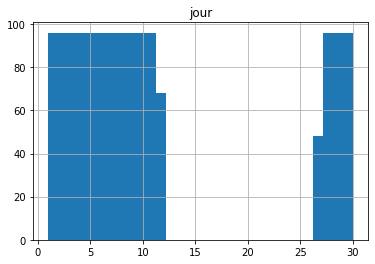

In [30]:
capteur_riviere['jour'] = capteur_riviere['dates'].apply(lambda x: x.day)
capteur_riviere.hist(column = ['jour'],bins=31)
capteur_riviere.head()

,#,dates,temperature_depth_1_C,temperature_depth_2_C,temperature_depth_3_C,temperature_depth_4_C,jour
0,1,2016-06-27 12:00:00,13.810,13.834,13.858,13.810,27
1,2,2016-06-27 12:15:00,13.834,13.858,13.882,13.834,27
2,3,2016-06-27 12:30:00,13.930,13.954,14.050,14.002,27
3,4,2016-06-27 12:45:00,13.882,13.954,14.026,13.954,27
4,5,2016-06-27 13:00:00,13.858,13.930,14.026,13.954,27


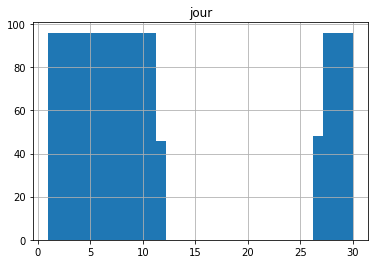

In [34]:
capteur_ZH['jour'] = capteur_ZH['dates'].apply(lambda x: x.day)
capteur_ZH.hist(column = ['jour'],bins=31)
capteur_ZH.head()

on a pris des mesures du 26 juin au 12 juillet, il est donc normal d'observer un tel creux dans l'histogramme

# Valeurs aberrantes

L'un des plus grands défis du nettoyage des données est l'identification et le traitement des valeurs aberrantes. En termes simples, les valeurs aberrantes sont des observations qui sont significativement différentes des autres points de données. Même les meilleurs algorithmes d'estimation des paramètres automatique seront moins performants si les observations aberrantes ne sont pas nettoyées des données, car elles impliquent des simulations obsolètes des variables.



In [32]:
print(capteur_riviere.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Titre de tracé : point_montberneux  1461 non-null   object        
 1   dates                               1460 non-null   datetime64[ns]
 2   tension_V                           1460 non-null   float64       
 3   temperature_stream_C                1460 non-null   float64       
 4   charge_m                            1460 non-null   float64       
 5   jour                                1460 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 68.6+ KB
None


In [33]:
print(capteur_ZH.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1438 entries, 0 to 1437
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   #                      1438 non-null   int64         
 1   dates                  1438 non-null   datetime64[ns]
 2   temperature_depth_1_C  1436 non-null   float64       
 3   temperature_depth_2_C  1436 non-null   float64       
 4   temperature_depth_3_C  1436 non-null   float64       
 5   temperature_depth_4_C  1436 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 67.5 KB
None


## Identification des valeurs aberrantes

La présence de valeurs aberrantes dans les données peut avoir de nombreuses raisons. Parfois, les valeurs aberrantes peuvent être authentiques, alors que dans d'autres cas, elles peuvent être dues à des erreurs de saisie de données. Il est important de comprendre les raisons des valeurs aberrantes avant de les nettoyer.

Nous allons commencer le processus de recherche des valeurs aberrantes en exécutant les statistiques sommaires sur les variables. Pour ce faire, nous utilisons la fonction describe() ci-dessous, qui fournit un résumé statistique de toutes les variables quantitatives.




## Tracez les graphiques de distribution pour les différentes variables

## Trouver les valeurs limites